In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torchvision import models
from torch.autograd import Function
from torch.autograd import Variable
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [3]:
torch.manual_seed(42)
np.random.seed(42)

In [4]:
%cd 'drive/My Drive/ACV Project/'

/content/drive/.shortcut-targets-by-id/1-uBPm49Eo3uaCU1aA2S0UwaL0_iMXQKS/ACV Project


In [5]:
dim = 64
X = np.load(f'./Dataset-{dim}/TR-Image.npy')
y = np.load(f'./Dataset-{dim}/TR-Mask.npy')

X_test = np.load(f'./Dataset-{dim}/TE-Image.npy')
y_test = np.load(f'./Dataset-{dim}/TE-Mask.npy')

In [6]:
print(y.max(), y.min(), np.unique(y))

1 0 [0 1]


In [7]:
print(X.shape, X.dtype, X.max(), X.min())

(10553, 64, 64, 3) uint8 255 0


In [8]:
num_train = int(len(X) * 0.8)

p = np.random.permutation(len(X))
X = X[p]
y = y[p]

X_train, X_val = X[ : num_train], X[num_train : ]
y_train, y_val = y[ : num_train], y[num_train : ]

In [9]:
print(X_train.shape, X_val.shape)
print(y_train.shape, y_val.shape)

(8442, 64, 64, 3) (2111, 64, 64, 3)
(8442, 64, 64) (2111, 64, 64)


In [10]:
class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.transform = transform
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img, lab = self.images[idx], self.labels[idx]
        if self.transform:
            img = self.transform(img).type(torch.FloatTensor)
        
        lab = torch.from_numpy(lab).type(torch.LongTensor)
        return (img, lab)

In [11]:
transform = transforms.Compose(
    [
     transforms.ToTensor(),
    ]
)

In [12]:
train_set = CustomDataset(X_train, y_train, transform=transform)
val_set = CustomDataset(X_val, y_val, transform=transform)
test_set = CustomDataset(X_test, y_test, transform=transform)

In [13]:
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32, shuffle=True)

In [14]:
itr = iter(train_loader)
img, lab = next(itr)

print(img.size(), lab.size())
print(img.type(), lab.type())

torch.Size([32, 3, 64, 64]) torch.Size([32, 64, 64])
torch.FloatTensor torch.LongTensor


In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [16]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()

        # 64x64
        self.conv1 = nn.Conv2d(3, 64, kernel_size = (3, 3), stride = 1, padding = 1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size = (3, 3), stride = 1, padding = 1)
        self.bn2 = nn.BatchNorm2d(128)
        self.pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2)

        #32x32
        self.conv3 = nn.Conv2d(128, 128, kernel_size = (3, 3), stride = 1, padding = 1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 128, kernel_size = (3, 3), stride = 1, padding = 1)
        self.bn4 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2)

        #16x16
        self.conv5 = nn.Conv2d(128, 128, kernel_size = (3, 3), stride = 1, padding = 1)
        self.bn5 = nn.BatchNorm2d(128)
        self.conv6 = nn.Conv2d(128, 128, kernel_size = (3, 3), stride = 1, padding = 1)
        self.bn6 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(kernel_size = 2, stride = 2)

        #8x8
        self.upconv1 = nn.ConvTranspose2d(128, 128, kernel_size = 2, stride = 2)
        self.bn7 = nn.BatchNorm2d(128)
        #16x16
        self.upconv2 = nn.ConvTranspose2d(128, 64, kernel_size = 2, stride = 2)
        self.bn8 = nn.BatchNorm2d(64)
        #32x32
        self.upconv3 = nn.ConvTranspose2d(64, 2, kernel_size = 2, stride = 2)
        #64x64

        self.upscore1 = nn.Upsample(scale_factor=8,mode='bilinear')
        self.upscore2 = nn.Upsample(scale_factor=4,mode='bilinear')
        self.upscore3 = nn.Upsample(scale_factor=2,mode='bilinear')

        self.outconv1 = nn.Conv2d(128,2,3,padding=1)
        self.outconv2 = nn.Conv2d(128,2,3,padding=1)
        self.outconv3 = nn.Conv2d(64,2,3,padding=1)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool1(x)

        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool2(x)

        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))
        x1 = self.pool3(x)

        x2 = F.relu(self.bn7(self.upconv1(x1)))
        x3 = F.relu(self.bn8(self.upconv2(x2)))
        x4 = self.upconv3(x3)

        return self.upscore1(self.outconv1(x1)), self.upscore2(self.outconv2(x2)), self.upscore3(self.outconv3(x3)), x4

In [17]:
model = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [18]:
def train(model, train_loader):
    model.train()
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs1, outputs2, outputs3, outputs4 = model(inputs)

        outputs = torch.cat((outputs1, outputs2, outputs3, outputs4))
        labels = torch.cat((labels, labels, labels, labels))
        
        loss = criterion(outputs, labels)
        running_loss += loss.item()
        loss.backward()
        optimizer.step()

        if i % 50 == 49:
            print(f'Iteration {i + 1:5} | { (running_loss / 50):.5f}')
            running_loss = 0.0


In [19]:
def accuracy(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    iters = 0
    running_loss = 0

    with torch.no_grad():
        for data in dataloader:
            images, labels = data[0].to(device), data[1].to(device)
            _,_,_,outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += (labels.size(0) * labels.size(1) * labels.size(2))
            correct += (predicted == labels).sum().item()
            iters += 1

    print('Accuracy of the network on the images: %.3f %%' % (100 * correct / total))
    return (running_loss / iters), (100 * correct / total)

In [20]:
def mIoU(model, dataloader, n_classes):
    model.eval()

    intersection = [0 for i in range(n_classes)]
    union = [0 for i in range(n_classes)]

    with torch.no_grad():
        for data in dataloader:
            images, labels = data[0].to(device), data[1].to(device)
            _,_,_,outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            for i in range(n_classes):
                intersect = torch.mul(predicted==i, labels==i).sum().item()
                uni = torch.add(predicted==i, labels==i).sum().item()
                intersection[i] += intersect
                union[i] += uni

    iou = [0 for i in range(n_classes)]
    for i in range(n_classes):
        iou[i] = intersection[i] / union[i]
    
    return sum(iou) / len(iou)

In [21]:
# start = 0
# epochs = 100
# train_acc = []
# train_loss = []
# val_acc = []
# val_loss = []

# for epoch in range(start, start + epochs):
#     print(f'Epoch {epoch + 1} started')
#     train(model, train_loader)
#     loss, acc = accuracy(model, train_loader)
#     train_acc.append(acc)
#     train_loss.append(loss)
#     loss, acc = accuracy(model, val_loader)
#     val_acc.append(acc)
#     val_loss.append(loss)

#     PATH = './CustomNet-64-v2/' + str(epoch + 1)
#     torch.save(model, PATH)

#     PATH += '-checkpoint'
#     torch.save({
#         'epoch': epoch+1,
#         'model-state-dict': model.state_dict(),
#         'train_acc': train_acc,
#         'train_loss': train_loss,
#         'val_acc': val_acc,
#         'val_loss': val_loss
#     }, PATH)

In [22]:
PATH = './CustomNet-64-v3/100-checkpoint'
checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model-state-dict'])

RuntimeError: ignored

In [ ]:
accuracy(model, test_loader)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Accuracy of the network on the images: 87.991 %


(0.6020659832817734, 87.99076205730724)

In [ ]:
mIoU(model, test_loader, 2)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


0.6594549486851164

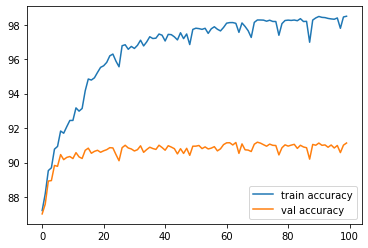

In [ ]:
train_acc = checkpoint['train_acc']
train_loss = checkpoint['train_loss']
val_acc = checkpoint['val_acc']
val_loss = checkpoint['val_loss']

plt.plot(list(range(checkpoint['epoch'])), train_acc)
plt.plot(list(range(checkpoint['epoch'])), val_acc)
plt.legend(['train accuracy', 'val accuracy'], loc='lower right')
plt.show()

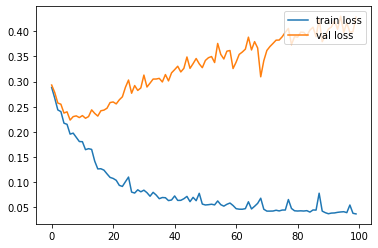

In [ ]:
plt.plot(list(range(checkpoint['epoch'])), train_loss)
plt.plot(list(range(checkpoint['epoch'])), val_loss)
plt.legend(['train loss', 'val loss'], loc='upper right')
plt.show()

In [ ]:
colors = [
    np.array([255,255,255], dtype=np.uint8),
    np.array([0,0,0], dtype=np.uint8),
]

In [ ]:
itr = iter(test_loader)

torch.Size([3, 64, 64]) | torch.Size([64, 64]) | torch.Size([64, 64])


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


torch.Size([3, 64, 64]) | torch.Size([64, 64]) | torch.Size([64, 64])
(64, 64, 3)


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


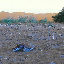

In [ ]:
model.eval()
img, lab = itr.next()
_,_,_,outputs = model(img.to(device))
_,predicted = torch.max(outputs, 1)

input, lab, pred = img[0], lab[0], predicted[0].cpu().detach()
print(f'{input.size()} | {lab.size()} | {pred.size()}')

img_size = input.shape[-1]
input_img = np.zeros((img_size, img_size, 3))
input_img[:, :, 0] = input[0]
input_img[:, :, 1] = input[1]
input_img[:, :, 2] = input[2]

input_img = (255 * input_img)
print(input_img.shape)
input_img = Image.fromarray(input_img.astype('uint8'), mode='RGB')
ground_truth = np.zeros((img_size, img_size, 3), dtype=np.uint8)
predicted = np.zeros((img_size, img_size, 3), dtype=np.uint8)

for i in range(img_size):
    for j in range(img_size):
        ground_truth[i][j] = colors[lab[i][j]]
        predicted[i][j] = colors[pred[i][j]]

ground_truth = Image.fromarray(ground_truth).convert('RGB')
predicted = Image.fromarray(predicted).convert('RGB')

display(input_img)

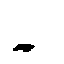

In [ ]:
display(ground_truth)

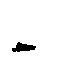

In [ ]:
display(predicted)